### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
# %pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

Repo card metadata block was not found. Setting CardData to empty.




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [3]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

### Tokenize the data

In [4]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [5]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [6]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=128, shuffle=False, collate_fn=transformers.default_data_collator,num_workers = 16, pin_memory = True
)

In [7]:
import numpy as np
accuracy = 0
model = model.to('cuda')
from tqdm import tqdm
for batch in tqdm(val_loader):
  with torch.no_grad():
    predicted = model(
        input_ids=batch['input_ids'].to('cuda'),
        attention_mask=batch['attention_mask'].to('cuda'),
        token_type_ids=batch['token_type_ids'].to('cuda')
    )

  accuracy += np.mean(torch.softmax(predicted.logits, dim=1).detach().cpu().data.numpy().argmax(axis=1) == batch['labels'].numpy())/len(val_loader)

  0%|          | 0/316 [00:00<?, ?it/s]c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 316/316 [01:14<00:00,  4.24it/s]


__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [8]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [6]:
import gc
torch.cuda.empty_cache()
gc.collect()

45

In [7]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base").to('cuda')

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=32, shuffle=True, collate_fn=transformers.default_data_collator,num_workers = 0, pin_memory = True
)

In [9]:
train_set = qqp_preprocessed['train']
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True, collate_fn=transformers.default_data_collator,num_workers = 0, pin_memory = True
)

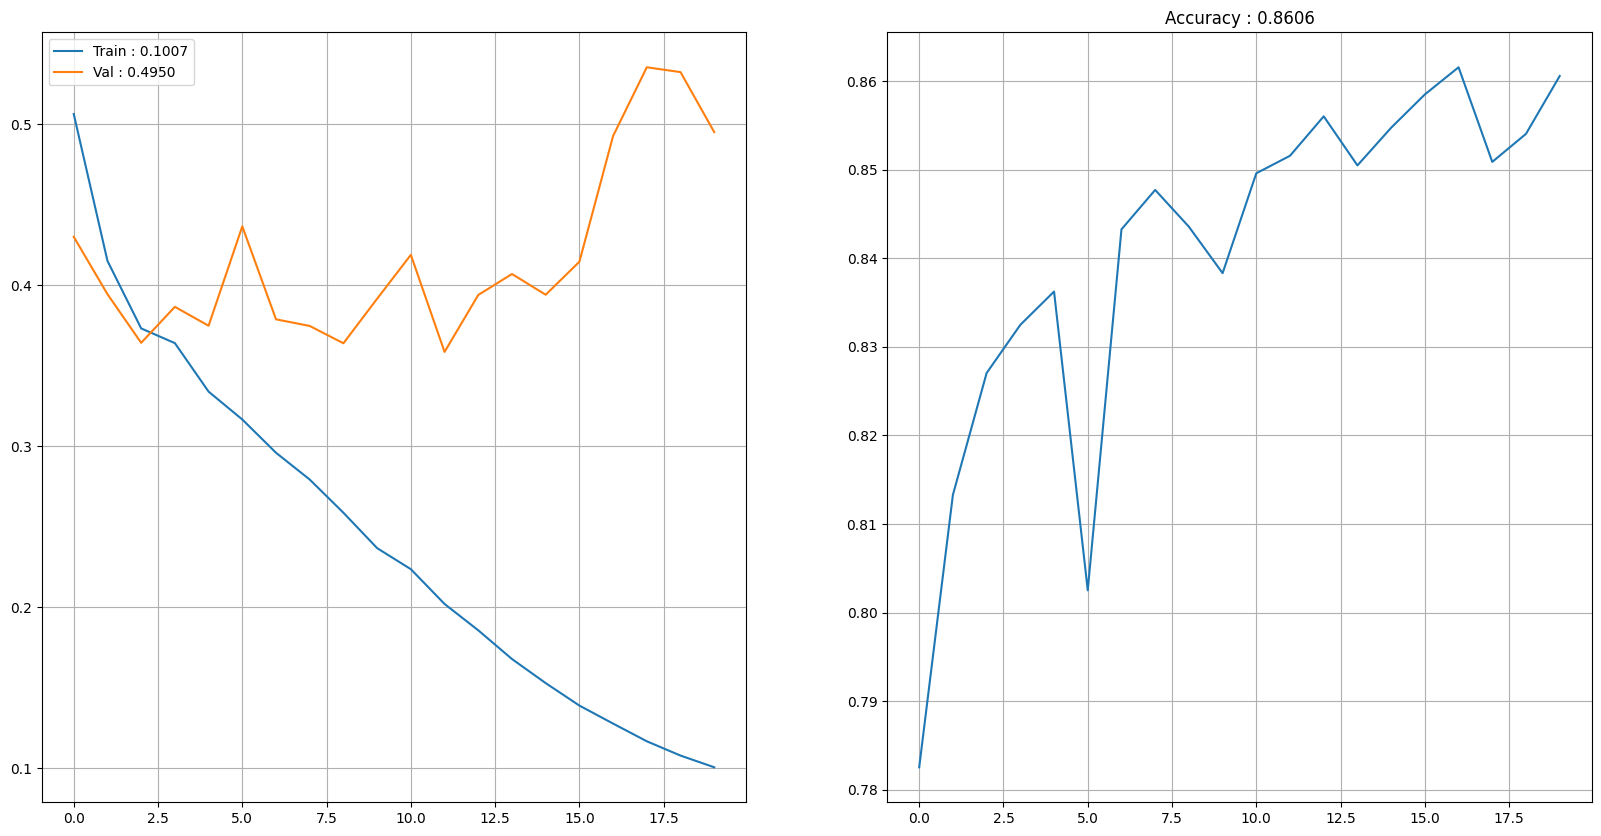

In [10]:
import numpy as np
model = model.to('cuda')
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
EPOCHS = 20
step = 0
VAL_SIZE = 0.25

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(
    [{'params':model.classifier.parameters(),'lr':1e-3},
     {'params':model.pooler.parameters(),'lr':1e-3},
     {'params':model.deberta.parameters(),'lr':1e-5,'weight_decay':1e-5}]
    )
total_loss = [0]
val_loss = [0]
accuracy = [0]
for epoch in range(EPOCHS):
    model.train()
    opt.param_groups[0]['lr'] = 1e-3 -  1e-3* (epoch/EPOCHS)**2
    opt.param_groups[1]['lr'] = 1e-3 -  1e-3* (epoch/EPOCHS)**2
    opt.param_groups[2]['lr'] = 1e-5 -  1e-5* (epoch/EPOCHS)**2
    for batch in tqdm(train_loader,desc=f"{epoch}/{EPOCHS}"):
        model.dropout.drop_prob = np.sin(step)/2
        step+=1

        opt.zero_grad()
        predicted = model(
            input_ids=batch['input_ids'].to('cuda'),
            attention_mask=batch['attention_mask'].to('cuda'),
            token_type_ids=batch['token_type_ids'].to('cuda')
        )

        loss = loss_fn(predicted['logits'],batch['labels'].to('cuda').long())
        loss.backward()
        total_loss[-1]+=loss.item()/len(train_loader)
        opt.step()


    model.eval()



    for i, batch in enumerate(tqdm(val_loader)):
        val_size = int(len(val_loader)*VAL_SIZE)
        if i < val_size:
            with torch.no_grad():
                predicted = model(
                    input_ids=batch['input_ids'].to('cuda'),
                    attention_mask=batch['attention_mask'].to('cuda'),
                    token_type_ids=batch['token_type_ids'].to('cuda')
                )
        
            loss = loss_fn(predicted['logits'],batch['labels'].to('cuda').long())
            val_loss[-1]+=loss.item()/val_size
            accuracy[-1] += np.mean(torch.softmax(predicted.logits, dim=1).detach().cpu().data.numpy().argmax(axis=1) == batch['labels'].numpy())/val_size
        else: break
    
    torch.save(model.state_dict(),f"deberta_{epoch}_{val_loss[-1]:.4f}.pt")
    clear_output(wait=True)
    plt.figure(figsize = (20,10))
    plt.subplot(1,2,1)
    plt.grid(True)
    plt.plot(total_loss)
    plt.plot(val_loss)
    plt.legend([f"Train : {total_loss[-1]:.4f}",f"Val : {val_loss[-1]:.4f}"])
    val_loss.append(0)
    total_loss.append(0)
    plt.subplot(1,2,2)
    plt.title(f"Accuracy : {accuracy[-1]:.4f}")
    plt.grid(True)
    plt.plot(accuracy)
    plt.show()
    accuracy.append(0)





### Task 3: try the full pipeline (1 point)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

In [11]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=32, shuffle=False, collate_fn=transformers.default_data_collator,num_workers = 0, pin_memory = True
)

In [21]:
from sklearn.metrics import f1_score
model.eval()
f1=0
import numpy as np
accuracy = 0
k=5
top_k = np.array([(0,-1) for _ in range(k)]).astype(float)
from tqdm import tqdm
for batch in tqdm(val_loader):
  with torch.no_grad():
    predicted = model(
        input_ids=batch['input_ids'].to('cuda'),
        attention_mask=batch['attention_mask'].to('cuda'),
        token_type_ids=batch['token_type_ids'].to('cuda')
    )
  preds = torch.softmax(predicted.logits, dim=1).detach().cpu().data.numpy()[:,1]

  for i in range(len(preds)):
    if preds[i] > min(top_k[:,1]):
      top_k[top_k.argmin(axis=0)[1]] = (batch['idx'][i].item(),preds[i])

  f1+= f1_score(batch['labels'].numpy(),(preds >0.5).astype(int))/len(val_loader)
  accuracy += np.mean((preds >0.5).astype(int) == batch['labels'].numpy())/len(val_loader)

100%|██████████| 1264/1264 [01:36<00:00, 13.16it/s]


In [22]:
f1,accuracy

(0.8025128937013664, 0.8597952927215203)

In [24]:
[print(i) for i in zip(val_set[top_k[:,0]]['text1'],val_set[top_k[:,0]]['text2'])];

('How do I add videos from youtube to a playlist and then download that playlist?', 'Is there any way to download YouTube playlists?')
('How much is known about the release date of the new Apple MacBook Pro?', 'When will Apple launch new MacBook Pro? Is it in 2016?')
('Which are oldest civilizations and why?', "Which is the world's oldest civilization?")
('How can I get entry in MIT?', 'What are the requirements for selection into MIT?')
('How can one overcome procrastination?', 'How should I avoid procrastination?')


__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.

In [26]:
test_set = qqp_preprocessed['test']
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=32, shuffle=False, collate_fn=transformers.default_data_collator,num_workers = 0, pin_memory = True
)

In [27]:
model.eval()
f1=0
import numpy as np
accuracy = 0
k=5
top_k = np.array([(0,-1) for _ in range(k)]).astype(float)
from tqdm import tqdm
for batch in tqdm(test_loader):
  with torch.no_grad():
    predicted = model(
        input_ids=batch['input_ids'].to('cuda'),
        attention_mask=batch['attention_mask'].to('cuda'),
        token_type_ids=batch['token_type_ids'].to('cuda')
    )
  preds = torch.softmax(predicted.logits, dim=1).detach().cpu().data.numpy()[:,1]

  for i in range(len(preds)):
    if preds[i] > min(top_k[:,1]):
      top_k[top_k.argmin(axis=0)[1]] = (batch['idx'][i].item(),preds[i])

100%|██████████| 12218/12218 [15:13<00:00, 13.37it/s]


In [29]:
[print(i) for i in zip(test_set[top_k[:,0]]['text1'],test_set[top_k[:,0]]['text2'])];

('How can one overcome procrastination?', 'What can I do to avoid procrastination?')
('How can I prepare myself to get an internship at Google?', 'How do I do internship at google?')
('What do I do to avoid procrastination?', 'How do I get rid of procrastination?')
('Is it physically possible to time travel back in time?', 'Time Travel Is It Possible?')
('Why do macarons stick to the parchment paper?', 'Why do macarons stick to parchment paper? How can this be prevented?')
